# Importing Necessary Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

# Defining Neural Network Model along with Sine activation function

- I am using Sine activation function because it is smooth and more accurately reflects a periodic oscillation

In [2]:
class SineActivation(nn.Module):
    def forward(self, input):
        return torch.sin(input)

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), SineActivation(),
            nn.Linear(64, 64), SineActivation(),
            nn.Linear(64, 64), SineActivation(),
            nn.Linear(64, 1)
        )

    def forward(self, z, xi):
        inputs = torch.cat((z, xi), dim=1)
        return self.net(inputs)

# Declaring Residual and Initial Condition Loss functions

- **physics_loss:** Here I have defined the physics loss by calculating the gradient of $x$ wrt $z$ and subsequently $\frac{dx}{dz}$ wrt $z$. I have also added a weight term to the residual loss, which is set on the basis of $\xi$, or damping factor that we take, so that small $\xi$ value will result in higher weight and vice-versa. I did this because for smaller $\xi$ value the solution is more oscillatory and thus the physics loss should be accordingly weighed.
- **initial_condition_loss:** This is just the calculation of loss incurred at initial condition, corresponding to different $\xi$ values taken. I have also added a weighing factor so that the neural network model strictly learns to adjust to the initial condition.

In [3]:
def physics_loss(model, z, xi):
    z.requires_grad_(True)
    
    x = model(z, xi)
    dx_dz = torch.autograd.grad(x, z, torch.ones_like(x), create_graph=True)[0]
    d2x_dz2 = torch.autograd.grad(dx_dz, z, torch.ones_like(dx_dz), create_graph=True)[0]
    
    residual = d2x_dz2 + 2 * xi * dx_dz + x
    weight = 1 / (1 + xi)
    return torch.mean(weight * residual**2)

def initial_condition_loss(model, lambda_ic, xi_samples):
    z0 = torch.zeros((len(xi_samples), 1), dtype=torch.float32, requires_grad=True)
    xi0 = xi_samples 

    x0_pred = model(z0, xi0)
    v0_pred = torch.autograd.grad(x0_pred, z0, torch.ones_like(x0_pred), create_graph=True)[0]

    ic_loss = torch.mean((x0_pred - 0.7) ** 2 + (v0_pred - 1.2) ** 2)
    return lambda_ic * ic_loss

# Setting up the model and training it

Here I am setting up the device-agnostic code, so that the model can run on GPU if it's available. Then I am instantiating the model, the optimizer and learning rate scheduler.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.7)

Setting up the number of epochs, weight factor for loss calculated at intial condition and defining collocation points.

In [5]:
epochs = 20001
lambda_ic = 10

z_train = torch.linspace(0, 20, 200, dtype=torch.float32).view(-1, 1).to(device)

# Training Loop

In this training loop I am re-weighting the *lambda_ic* factor at every 1000 epochs by a factor of 0.9, as I saw that this helped with the training.

In [6]:
for epoch in range(epochs):
    optimizer.zero_grad()
    
    xi_train = (torch.rand(200, 1) * 0.3 + 0.1).to(device)
    
    loss_pde = physics_loss(model, z_train, xi_train)
    loss_ic = initial_condition_loss(model, lambda_ic, xi_train)
    loss = loss_pde + loss_ic

    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % 1000 == 0 and lambda_ic > 1.0:
        lambda_ic *= 0.9

    if epoch % 2000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}", flush=True)

Epoch 0, Loss: 20.735368728637695
Epoch 2000, Loss: 0.00197867164388299
Epoch 4000, Loss: 0.0015107771614566445
Epoch 6000, Loss: 0.0002502085408195853
Epoch 8000, Loss: 0.00039816793287172914
Epoch 10000, Loss: 0.0005950320046395063
Epoch 12000, Loss: 5.842721293447539e-05
Epoch 14000, Loss: 0.00010185915016336367
Epoch 16000, Loss: 0.0004153420450165868
Epoch 18000, Loss: 2.4799222956062295e-05
Epoch 20000, Loss: 8.915261423680931e-05


# Numerical Method Implementation that serves as a benchmark to validate the performance of the PINN solution.

---

## `damped_oscillator(z, y, xi)`
Defines the differential equations governing a damped harmonic oscillator.  

**Parameters:**
- `z` – Independent variable.
- `y` – State vector `[x, v]`.
- `xi` – Damping coefficient.

**Returns:**
- A NumPy array `[dx/dz, dv/dz]`, where:
  - `dx/dz = v`
  - `dv/dz = -2 * xi * v - x`

---

## `rk4(f, z, y, h, xi)`
Implements the fourth-order Runge-Kutta (RK4) method for solving ordinary differential equations.  

**Parameters:**
- `f` – Function representing the ODE (in our case, `damped_oscillator`).
- `z` – Current value of the independent variable.
- `y` – Current state `[x, v]`.
- `h` – Step size.
- `xi` – Damping coefficient.

**Returns:**
- Updated state `[x, v]` after one RK4 step.

---

## `solve_damped_oscillator_rk4(x0, v0, xi, z_max, h)`
Numerically solves the damped harmonic oscillator using the RK4 method.  

**Parameters:**
- `x0` – Initial position.
- `v0` – Initial velocity.
- `xi` – Damping coefficient.
- `z_max` – Maximum value for z.
- `h` – Step size.

**Returns:**
- `z_values` – Array of `z` values.
- `x_values` – Array of position values `x(z)`.

This method initializes the system with given conditions and iteratively applies RK4 to solve the equations.

In [7]:
def damped_oscillator(z, y, xi):
    x1, x2 = y
    dx1_dz = x2
    dx2_dz = -2 * xi * x2 - x1
    return np.array([dx1_dz, dx2_dz])

def rk4(f, z, y, h, xi):
    k1 = h * f(z, y, xi)
    k2 = h * f(z + h/2, y + k1/2, xi)
    k3 = h * f(z + h/2, y + k2/2, xi)
    k4 = h * f(z + h, y + k3, xi)
    return y + (k1 + 2*k2 + 2*k3 + k4) / 6

def solve_damped_oscillator_rk4(x0, v0, xi, z_max, h):
    z_values = np.arange(0, z_max + h, h)
    y_values = np.zeros((len(z_values), 2))
    y_values[0] = [x0, v0]

    for i in range(1, len(z_values)):
        y_values[i] = rk4(damped_oscillator, z_values[i-1], y_values[i-1], h, xi)

    return z_values, y_values[:, 0]

$x_0 \longrightarrow$ initial position <br/>
$v_0 \longrightarrow$ initial velocity

In [8]:
x0, v0 = 0.7, 1.2
z_max, h = 20, 0.05

# Plotting the PINN and RK4 solution for various values of $\xi$

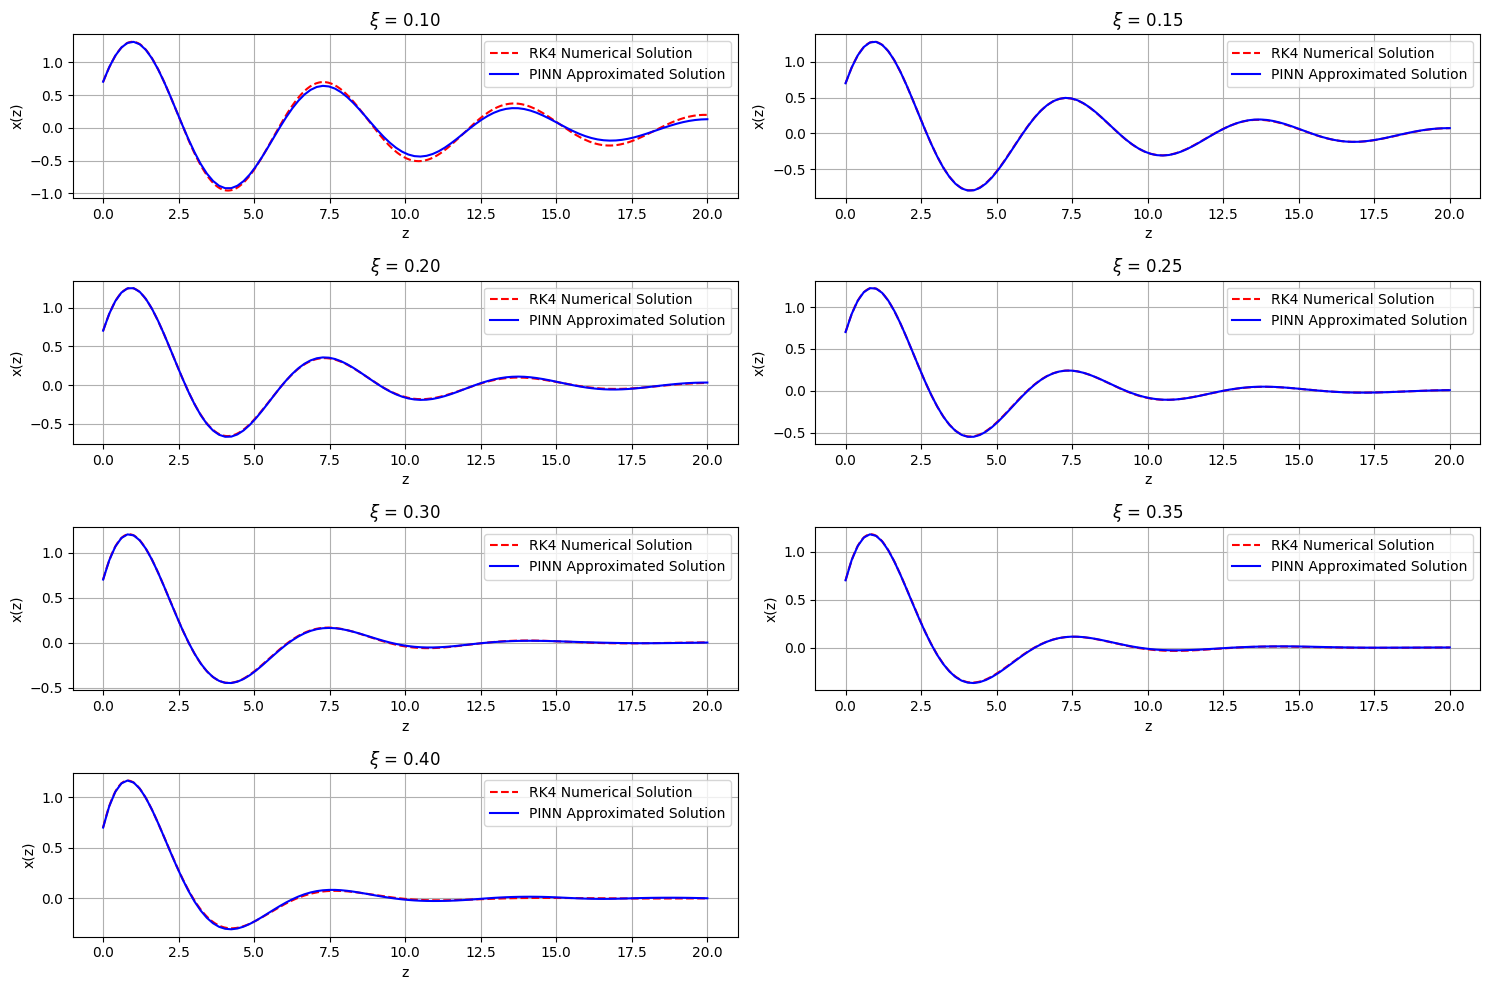

In [10]:
xi_test_vals = np.arange(0.1, 0.4, 0.05)

num_plots = len(xi_test_vals)

cols = 2  
rows = (num_plots + cols - 1) // cols 

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

for i, xi_val in enumerate(xi_test_vals):

    z_values_rk4, x_values_rk4 = solve_damped_oscillator_rk4(x0, v0, xi_val, z_max, h)

    z_test = torch.linspace(0, 20, 100).view(-1, 1)
    xi_test = torch.full_like(z_test, xi_val)
    x_pred = model(z_test, xi_test).detach().numpy()

    ax = axes[i]
    ax.plot(z_values_rk4, x_values_rk4, 'r--', label='RK4 Numerical Solution')
    ax.plot(z_test.numpy(), x_pred, 'b-', label='PINN Approximated Solution')
    ax.set_xlabel('z')
    ax.set_ylabel('x(z)')
    ax.set_title(fr'$\xi$ = {xi_val:.2f}')
    ax.legend()
    ax.grid(True)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("Damped_HO.jpg")
plt.show()
